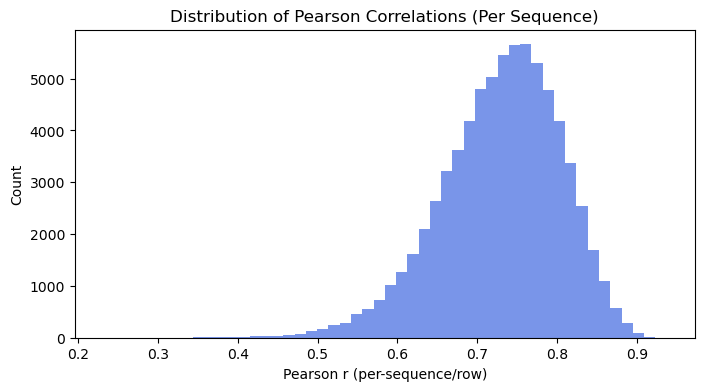

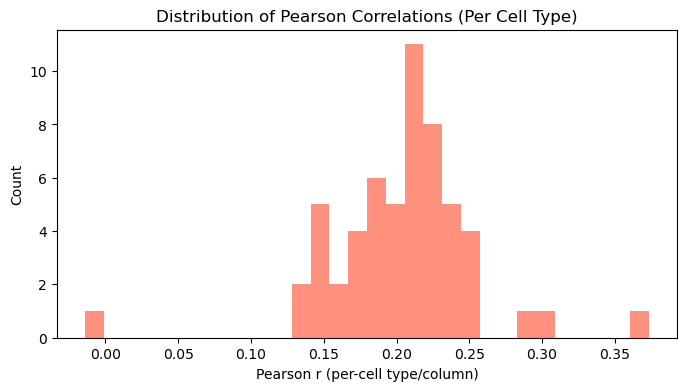

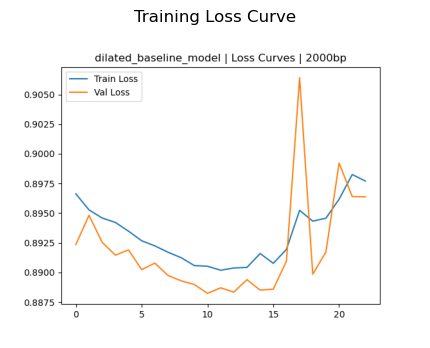

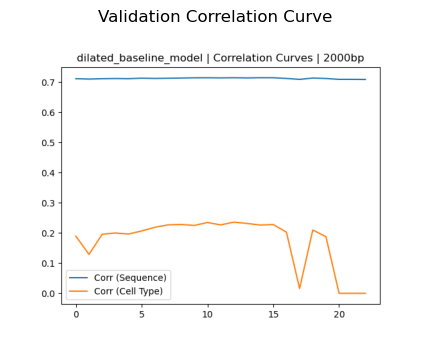

In [5]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from dilated_baseline_model import ATACSeqCNN, one_hot_encode, load_and_split_data

# ---- Parameters ----
sequence_length = 2000
num_targets = ...  # Set this to the number you used for training (or infer from CSV)
model_name = "dilated_baseline_model"
output_dir = f"../../src/models/outputs/{model_name}_{sequence_length}"
dataset_path = f"../../data/embryo/processed/atac_peaks_with_sequences_{sequence_length}.csv"
best_model_path = f"{output_dir}/{model_name}_{sequence_length}bp_best.pth"

# ---- Load Data ----
df = pd.read_csv(dataset_path)
num_targets = df.shape[1] - 4
X_train, X_val, y_train, y_val = load_and_split_data(dataset_path, sequence_length)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

# ---- Load Model ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ATACSeqCNN(sequence_length, num_targets).to(device)
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# ---- Get Predictions on Validation Set ----
all_preds, all_targets = [], []
with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        preds = model(batch_X)
        all_preds.append(preds.cpu())
        all_targets.append(batch_y.cpu())
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# ---- Compute Per-Sequence and Per-Celltype Pearson Correlations ----
def rowwise_corr(a, b):
    corrs = []
    for i in range(a.shape[0]):
        cor = np.corrcoef(a[i], b[i])[0, 1]
        corrs.append(cor)
    return np.array(corrs)

def colwise_corr(a, b):
    corrs = []
    for i in range(a.shape[1]):
        cor = np.corrcoef(a[:, i], b[:, i])[0, 1]
        corrs.append(cor)
    return np.array(corrs)

row_corrs = rowwise_corr(all_preds, all_targets)
col_corrs = colwise_corr(all_preds, all_targets)

# ---- Plot Distributions ----
plt.figure(figsize=(8, 4))
plt.hist(row_corrs, bins=50, alpha=0.7, color='royalblue')
plt.xlabel("Pearson r (per-sequence/row)")
plt.ylabel("Count")
plt.title("Distribution of Pearson Correlations (Per Sequence)")
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(col_corrs, bins=30, alpha=0.7, color='tomato')
plt.xlabel("Pearson r (per-cell type/column)")
plt.ylabel("Count")
plt.title("Distribution of Pearson Correlations (Per Cell Type)")
plt.show()

# ---- Reload & Show Previous Training/Validation Plots ----
from PIL import Image

plt.figure(figsize=(8, 4))
img = Image.open(f"{output_dir}/training_curve_{sequence_length}bp.png")
plt.imshow(img)
plt.axis('off')
plt.title("Training Loss Curve")
plt.show()

plt.figure(figsize=(8, 4))
img = Image.open(f"{output_dir}/validation_correlation_curve_{sequence_length}bp.png")
plt.imshow(img)
plt.axis('off')
plt.title("Validation Correlation Curve")
plt.show()


In [13]:
import pandas as pd
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

# Load the original dataframe to get cell type names
df = pd.read_csv("../../data/embryo/processed/atac_peaks_with_sequences_2000.csv")
celltype_names = df.columns[:-4].tolist()  # assumes last 4 columns are metadata

# Compute correlations
peak_corrs = np.array([
    pearsonr(all_preds[i], all_targets[i])[0] if np.std(all_targets[i]) > 0 else 0
    for i in range(all_targets.shape[0])
])

celltype_corrs = np.array([
    pearsonr(all_preds[:, j], all_targets[:, j])[0] if np.std(all_targets[:, j]) > 0 else 0
    for j in range(all_targets.shape[1])
])



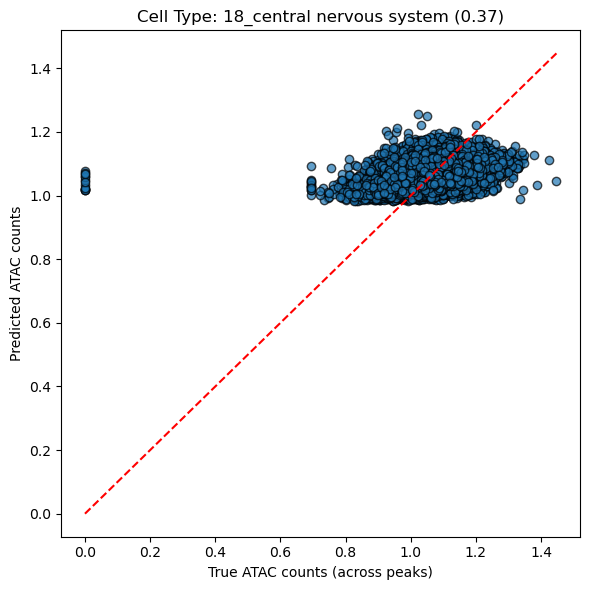

In [14]:
# Index and name of the most predictable cell type
high_corr_celltype_idx = np.argmax(celltype_corrs)
high_corr_celltype_name = celltype_names[high_corr_celltype_idx]

true_vals = all_targets[:, high_corr_celltype_idx]
pred_vals = all_preds[:, high_corr_celltype_idx]

plt.figure(figsize=(6, 6))
plt.scatter(true_vals, pred_vals, alpha=0.7, edgecolor='k')
plt.plot([true_vals.min(), true_vals.max()], [true_vals.min(), true_vals.max()], 'r--')
plt.xlabel("True ATAC counts (across peaks)")
plt.ylabel("Predicted ATAC counts")
plt.title(f"Cell Type: {high_corr_celltype_name} ({celltype_corrs[high_corr_celltype_idx]:.2f})")
plt.tight_layout()
plt.show()


Chosen peak index: 55042 (correlation = 0.937)


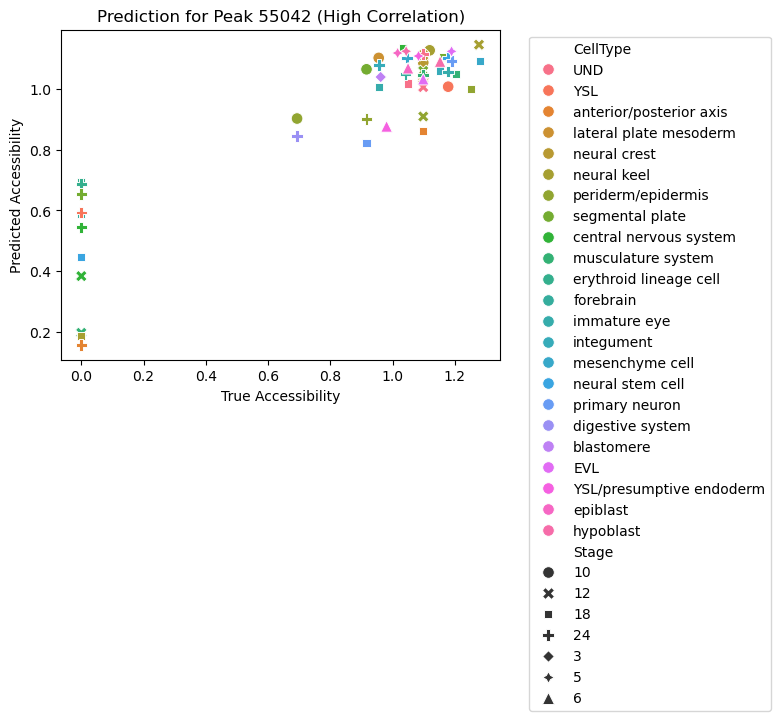

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load column names
df = pd.read_csv("../../data/embryo/processed/atac_peaks_with_sequences_2000.csv")
column_names = df.columns[:-4].tolist()

# Parse stage and cell type
valid_names = [name for name in column_names if "_" in name]
stages, cell_types = zip(*[name.split("_", 1) for name in valid_names])

# Convert to numpy arrays
stages = np.array(stages)
cell_types = np.array(cell_types)

# Compute correlations per peak
peak_corrs = np.array([
    pearsonr(all_preds[i], all_targets[i])[0] if np.std(all_targets[i]) > 0 else 0
    for i in range(all_targets.shape[0])
])

# Select a high-correlation peak
high_corr_peak_idx = np.argmax(peak_corrs)
print(f"Chosen peak index: {high_corr_peak_idx} (correlation = {peak_corrs[high_corr_peak_idx]:.3f})")

# Prepare data for plotting
df_plot = pd.DataFrame({
    "True": all_targets[high_corr_peak_idx, :len(valid_names)],
    "Pred": all_preds[high_corr_peak_idx, :len(valid_names)],
    "Stage": stages,
    "CellType": cell_types
})

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_plot,
    x="True", y="Pred",
    hue="CellType", style="Stage", s=70
)
plt.title(f"Prediction for Peak {high_corr_peak_idx} (High Correlation)")
plt.xlabel("True Accessibility")
plt.ylabel("Predicted Accessibility")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


______________________________________


In [ ]:
import sys
import os 
sys.path.append(os.path.abspath("../../src"))
from models.dilated_baseline_model import ATACSeqCNN
from utils.preprocess import load_and_split_data, normalize_input_data
from utils.training import train_model
import torch
import torch.nn as nn
import torch.optim as optim
import os

sequence_length = 2000
model_name = "dilated_baseline_model"
print(f"Current working directory: {os.getcwd()}")
dataset_path = "../../data/embryo/processed/atac_peaks_with_sequences_2000.csv"

output_dir = f"../../src/models/outputs/{model_name}_{sequence_length}_raw"
os.makedirs(output_dir, exist_ok=True)
model = ATACSeqCNN(sequence_length, num_targets=55)  
X_train, X_val, y_train, y_val, df = load_and_split_data(dataset_path, sequence_length)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val, y_val), batch_size=16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.PoissonNLLLoss(log_input=False)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

train_model(
    model, train_loader, val_loader, criterion, optimizer,
    num_epochs=300, early_stopping_patience=10, device=device,
    output_dir=output_dir, model_name=model_name, sequence_length=sequence_length
)

Current working directory: /sasselab3/home/mourouzidou/zebrafish_development/notebooks/embryo
Loaded 370058 rows from ../../data/embryo/processed/atac_peaks_with_sequences_2000.csv
Filtered to 370058 rows with sequence length 2000
Target shape: (370058, 55)
X_train shape: torch.Size([289686, 4, 2000]), y_train shape: torch.Size([289686, 55])
Epoch 1 - Train Loss: 0.7886 - Val Loss: 0.7857 - Corr (Seq): 0.5742 - Corr (Type): 0.1655
Model saved at epoch 1
Epoch 2 - Train Loss: 0.7853 - Val Loss: 0.7859 - Corr (Seq): 0.5734 - Corr (Type): 0.1969
Model saved at epoch 2
Epoch 3 - Train Loss: 0.7850 - Val Loss: 0.7813 - Corr (Seq): 0.5766 - Corr (Type): 0.1995
Model saved at epoch 3
Epoch 4 - Train Loss: 0.7836 - Val Loss: 0.7810 - Corr (Seq): 0.5767 - Corr (Type): 0.2077
Model saved at epoch 4
Epoch 5 - Train Loss: 0.7836 - Val Loss: 0.7800 - Corr (Seq): 0.5771 - Corr (Type): 0.2094
Model saved at epoch 5
Epoch 6 - Train Loss: 0.7824 - Val Loss: 0.7800 - Corr (Seq): 0.5774 - Corr (Type): 0.

([0.7886309655354219,
  0.78531705090766,
  0.7849638930713355,
  0.7835855528845598,
  0.7835664015987966,
  0.7823817065463177,
  0.7815027049427123,
  0.7793928850695242,
  0.7799658133162459,
  0.7777393448883482,
  0.7769968769279855,
  0.7756798884380882,
  0.7766101458652578,
  0.7742162670145558,
  0.7727038975507531,
  0.7720456370415377,
  0.7715677784402555,
  0.7780158515695734,
  0.771675637808476,
  0.7696278828666261,
  0.7690758408070612,
  0.7681642074315281,
  0.7684006216538409,
  0.7672805341583424,
  0.7669889627669143],
 [0.7856506072696606,
  0.785910564195958,
  0.7813382545711508,
  0.7810074563500038,
  0.7799810594196912,
  0.7799589867780733,
  0.777396745232355,
  0.7761260344747715,
  0.774795243765708,
  0.7746398972382971,
  0.7735046330886851,
  0.7726513036781815,
  0.7747094501996306,
  0.7732714055473827,
  0.7719626453390737,
  0.773952873174552,
  0.7744446008045013,
  0.7741230964114901,
  0.772493917008589,
  0.7737094504272293,
  0.7758589577119

In [ ]:
import sys
import os
sys.path.append(os.path.abspath("../../src"))
from utils.preprocess import *

dataset_path = "../../data/embryo/processed/atac_peaks_with_sequences_2000.csv"
load_and_split_data(
    dataset_path, sequence_length=2000, 
    log_transform_flag=False, normalize=None, 
    drop_n_last_cols=5, plot_norm=True, output_dir="../../src/models/outputs/dilated_baseline_model_2000_raw"
)